In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()
!pip install torch torchvision
!pip install d2l==1.0.0b0
!conda install -c conda-forge torchmetrics

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:16
🔁 Restarting kernel...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 887.4/887.4 MB 151.6 MB/s eta 0:00:01tcmalloc: large alloc 1109270528 bytes == 0x56379eb80000 @  0x7f805a6bc680 0x7f805a6dcda2 0x5637675f2a57 0x56376765b30b 0x56376765b1c3 0x5637675d4b83 0x5637675b6c85 0x5637675b5351 0x5637675c726c 0x5637675b6c85 0x5637675b5351 0x5637675c726c 0x5637675b6c85 0x5637675b5351 0x5637675c726c 0x5637675b6c85 0x5637675b5351 0x5637675c726c 0x5637675b6c85 0x5637675b5351 0x5637675c726c 0x5637675b6c85 0x5637675c71d6 0x5637675b6c85 0x5637675b5351 0x5637675c726c 0x5637675b76fa 0x5637675b5351 0x5637675c726c 0x5637675b6c85 0x5637675b5351
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.4/887.4 MB 1.7 MB/s et

Solving environment: / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - failed with initial frozen solve. Retrying with flexible solve.
Solving environment: - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ 

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import os
import torch
import torchvision
from torchvision import transforms
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torchsummary import summary
from d2l import torch as d2l
from pathlib import Path
from torchmetrics.classification import BinaryF1Score
import sys
import nibabel as nib
import numpy as np
import gc
import skimage
import h5py
import math

/usr/local/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [ ]:
class LITSBinaryDataset(Dataset):
    def __init__(self, fileName):
        super().__init__()

        self.fileName = fileName
        self.length = 0

        file = h5py.File(self.fileName, "r")

        for scan in list(file.keys()):
            self.length += len(list(file[scan].keys()))

        file.close()

    def __len__(self):
        return self.length
        #return len(list(file.keys())) * len(list(file.keys()))

    def __getitem__(self, idx):
        file = h5py.File(self.fileName, "r")

        scanNum = 0
        currInd = 0
        scan = list(file.keys())[0]
        while currInd + len(list(file[scan].keys())) <= idx:
            currInd += len(list(file[scan].keys()))
            scanNum += 1
            scan = list(file.keys())[scanNum]

        sliceNum = idx - currInd

        data = file[list(file.keys())[scanNum]]["Slice" + str(sliceNum)]["Volume"]
        label = file[list(file.keys())[scanNum]]["Slice" + str(sliceNum)].attrs.get("ImageLabel")

        #result = {"X": data[...], "Y": label}

        result = []
        result.append(torch.Tensor(data[...]).unsqueeze(0))
        result.append(torch.Tensor(label).squeeze(0))

        file.close()

        return result

In [ ]:
class convBlock(nn.Module):
    def __init__(self, inChannels, outChannels, batchNorm, strides) -> None:
        super().__init__()

        self.conv1 = nn.Conv2d(inChannels, outChannels, kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(outChannels, outChannels, kernel_size=3, padding=1)

        nn.init.uniform_(self.conv1.weight)
        nn.init.uniform_(self.conv2.weight)

        if(batchNorm):
            self.bn1 = nn.BatchNorm2d(outChannels)
        else:
            self.bn1 = False

    def forward(self, X):
        Y = self.conv1(X)

        if(self.bn1):
            Y = self.bn1(Y)

        Y = F.relu(Y)

        return torch.Tensor(F.relu(self.conv2(Y)))

In [ ]:
class EncoderBlock(nn.Module):
    def __init__(self, inChannels, outChannels, strides) -> None:
        super().__init__()

        self.conv = convBlock(inChannels, outChannels, True, strides)
        self.pool = nn.MaxPool2d(2, stride=strides)

    def forward(self, X):

        Y = self.conv.forward(X)

        #return torch.Tensor(self.pool(Y)), Y
        return self.pool(Y)

In [ ]:
class DecoderBlock(nn.Module):
    def __init__(self, inChannels, outChannels, strides) -> None:
        super().__init__()

        self.convTrans = nn.ConvTranspose2d(inChannels, outChannels, 2, stride=strides, padding=1)
        self.conv = convBlock(outChannels, outChannels, True, strides)

    def forward(self, X, skipFeatures):
        Y = self.convTrans(X)
        Y = torch.cat(X, skipFeatures)
        return self.conv(Y)

In [ ]:
def evaluate_accuracy(net, testIter, device=None):
    if isinstance(net, nn.Module):
        net.eval()
        if not device:
            device = next(iter(net.parameters())).device

    metric = d2l.Accumulator(2)

    with torch.no_grad():
        for X, y in testIter:
            X = X.to(device)
            y = y.to(device)

            metric.add(d2l.accuracy(torch.round(torch.clamp(net(X), min=0, max=1)), y), y.numel())

    return metric[0] / metric[1]

In [ ]:
def train(net: nn.Sequential, trainIter, testIter, numEpochs, learnRate, batchSize, device: torch.device, lossFunc = nn.BCEWithLogitsLoss()):
    print(f"Training on {device}")
    
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=learnRate)
    numBatches = len(trainIter)

    anim1 = d2l.Animator(xlabel="Epoch", xlim=[0, numEpochs - 1], legend=["Train Accuracy", "Test Accuracy"])
    anim2 = d2l.Animator(xlabel="Epoch", xlim=[0, numEpochs - 1], legend=["Loss"])

    for epoch in range(numEpochs):
        net.train()
        metric = d2l.Accumulator(2)

        for i, (X, y) in enumerate(trainIter):
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)

            yhat = net(X)

            prediction = torch.round(torch.clamp(yhat, min=0, max=1)).to(device)

            l = lossFunc(yhat.squeeze(1), y)
            l.backward()
            optimizer.step()

            #print(f"{yhat} {prediction} {y} {l}")

            metric.add(l, d2l.accuracy(prediction, y) / batchSize)

        anim1.add(epoch, ((metric[1] / (numBatches * batchSize)), evaluate_accuracy(net, testIter, device)))
        anim2.add(epoch, (metric[0] / (numBatches * batchSize)))
        #print(f"Loss: {sumLoss / numBatches} Accuracy: {sumAcc / (numBatches * batchSize)}")

Intialized model
Training on cuda


KeyboardInterrupt: ignored

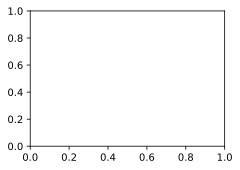

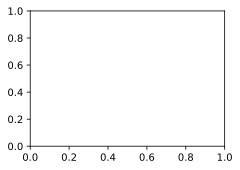

In [ ]:
gc.collect()

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
#device = torch.device("cpu")

batchSize = 1
learnRate = 0.00001
epochs = 10
testSetSize = 1

block1 = EncoderBlock(1, 64, 1)
block2 = EncoderBlock(64, 128, 1)
block3 = EncoderBlock(128, 256, 1)
block4 = EncoderBlock(256, 512, 1)
block5 = EncoderBlock(512, 1024, 1)

net = nn.Sequential(block1, block2, block3, block4, nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(), nn.Linear(512, 1))
#print(summary(net, (1, 512, 512)))

print("Intialized model")

"""
xDir = "drive/MyDrive/LiverDataset/Volumes/"
yDir = "drive/MyDrive/LiverDataset/Segmentations/"
numFiles = len([name for name in os.listdir(xDir) if os.path.isfile(os.path.join(xDir, name))])

xData = []
yData = []

xTestData = []
yTestData = []

for i, name in enumerate(os.listdir(xDir)):
    if name[0] == '.':
        continue

    ctScan = nib.load(xDir + name)
    data = ctScan.get_fdata()

    for plane in range(data.shape[2]):
        p = data[:,:,plane].astype(np.int16)

        if numFiles - i > testSetSize:
            xData.append(p)
        else:
            xTestData.append(p)

for i, name in enumerate(os.listdir(yDir)):
    if name[0] == '.':
        continue

    segmentation = nib.load(yDir + name)
    data = segmentation.get_fdata()

    for plane in range(data.shape[2]):
        p = data[:,:,plane].astype(np.int16)

        if(numFiles - i > testSetSize):
            yData.append(min(np.amax(p), 1))
        else:
            yTestData.append(min(np.amax(p), 1))

tensorX = torch.Tensor(np.array(xData)).unsqueeze(1)
tensorY = torch.Tensor(np.array(yData))

tensorTestX = torch.Tensor(np.array(xData)).unsqueeze(1)
tensorTestY = torch.Tensor(np.array(yData))

print(tensorX.shape)
print(tensorY.shape)

print("Finished loading data")

trainDataset = TensorDataset(tensorX, tensorY)
testDataset = TensorDataset(tensorTestX, tensorTestY)
"""

trainDataset = LITSBinaryDataset("drive/MyDrive/TrainDataset.hdf5")
testDataset = LITSBinaryDataset("drive/MyDrive/TestDataset.hdf5")

trainIter = DataLoader(trainDataset, batch_size=batchSize, shuffle=True)
testIter = DataLoader(testDataset, batch_size=batchSize)

train(net, trainIter, testIter, epochs, learnRate, batchSize, device)